# Import Libraries

In [46]:
import pandas as pd
import numpy as np
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import os
from collections import Counter
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation, NMF
from gensim.models import HdpModel, CoherenceModel
import gensim.corpora as corpora
import hdp
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_colwidth', None)  # Show full content in each cell
pd.set_option('display.width', 1000)  # Set max width

# Load spaCy's English model
nlp = spacy.load('en_core_web_sm')

# Modules

In [7]:
def preprocess_text(text):
    custom_stopwords = set(nlp.Defaults.stop_words)

    doc = nlp(text.lower().strip())  # Lowercase and remove whitespace
    
# Process tokens: lemmatize, filter stopwords/punct/numbers
    tokens = [
        token.lemma_ 
        for token in doc 
        if (
            (not token.is_stop) and
            not token.is_punct and token.is_alpha                                  # Remove punctuation
            # (token.is_alpha or token.like_num)                       # Keep words/numbers
        )
    ]

    return ' '.join(tokens)

In [8]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys


In [9]:
def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [10]:
def get_top_n_words(n , n_topics, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [11]:
def get_mean_topic_vectors(n_topics, keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [12]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:][::-1]
        top_features = feature_names[top_features_ind]
        print(f"Topic {topic_idx + 1}:  {' '.join(top_features)}")


# Pre-Processing

In [13]:
# Load dataset
df = pd.DataFrame()
for i in range(1,2):
    q_df = pd.read_csv(os.getcwd() + '/video_data' + str(i) + '.csv')
    df = pd.concat([df , q_df])
df['processed_title'] = df['title'].apply(preprocess_text)

In [14]:
# TF-IDF vectorization
token_pattern = r"(?u)\b[a-zA-Z]{3,}\b"
vectorizer = TfidfVectorizer(
    min_df= 2 ,max_df=0.8 , ngram_range=(1,2), use_idf= True, norm= 'l2', token_pattern= token_pattern
                             )
tfidf = vectorizer.fit_transform(df['processed_title'])

tfidf_df = pd.DataFrame(tfidf.toarray(), columns= vectorizer.get_feature_names_out(), index=df.index)
tfidf_df.shape

(1605, 1575)

# Modelling

In [15]:
# Define number of topics
n_topics = 10

### LSA

This is effectively just a truncated singular value decomposition of a (very high-rank and sparse) document-term matrix, with only the n_topics largest singular values preserved.

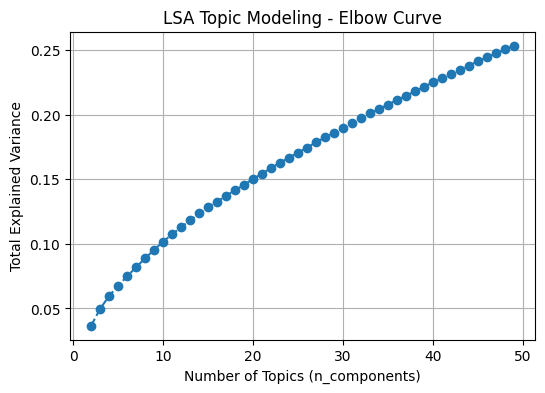

In [ ]:
explained_variances = []
k_range = range(2, 50)  # Try different topic numbers

for k in k_range:
    svd = TruncatedSVD(n_components=k)
    svd.fit(tfidf_df)
    explained_variances.append(svd.explained_variance_ratio_.sum())

# Plot elbow curve
plt.figure(figsize=(6, 4))
plt.plot(k_range, explained_variances, marker='o', linestyle='--')
plt.xlabel('Number of Topics (n_components)')
plt.ylabel('Total Explained Variance')
plt.title('LSA Topic Modeling - Elbow Curve')
plt.grid(True)
plt.show()


10 is optimal n_topics

In [33]:
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(tfidf_df)

In [34]:
'''
Taking the  argmax of each headline in this topic matrix will give the predicted topics of each headline in the sample. 
We can then sort these into counts of each topic.
  '''

lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

top_n_words_lsa = get_top_n_words(10, n_topics, lsa_keys, tfidf, vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  bitcoin crypto news bullish pump bitcoin crypto explain scam crash break
Topic 2:  explain programmer programmer explain ethereum bitcoin hack eos code ethereum programmer lightning
Topic 3:  crypto week week crypto news btc blockchain trump bad big crash
Topic 4:  buy buy bitcoin bitcoin time sell altcoin rich crypto buy token crypto
Topic 5:  bull market run bull run bull market bear coin bear market bitcoin bull cycle
Topic 6:  ethereum price bitcoin price price prediction prediction bitcoin bullish interview head start
Topic 7:  altcoin memecoin gain millionaire bitcoin altcoin right wealth pump watch gem
Topic 8:  moon binance month billion million legend beginning send ralph bitcoin moon
Topic 9:  money bank new war collapse ethereum system private civil war civil
Topic 10:  trading day strategy trade step trading strategy bybit guide beginner tutorial


### LDA
 LDA is instead a generative probabilistic process, designed with the specific goal of uncovering latent topic structure in text corpora.

In [52]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2)
count_matrix = vectorizer.fit_transform(df['processed_title'])


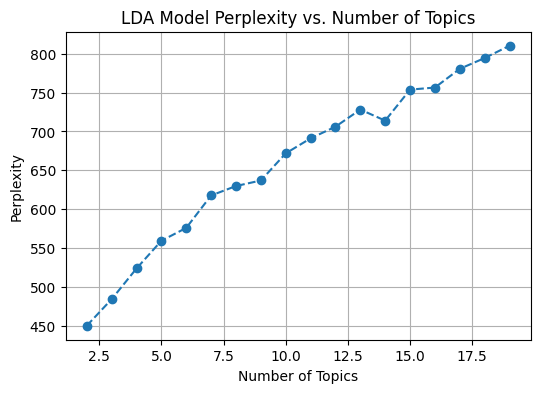

In [54]:
perplexities = []
k_range = range(2, 20)

for k in k_range:
    lda = LatentDirichletAllocation(n_components=k, random_state=42)
    lda.fit(count_matrix)
    perplexities.append(lda.perplexity(count_matrix))  # Lower is better

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(k_range, perplexities, marker='o', linestyle='--')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.title('LDA Model Perplexity vs. Number of Topics')
plt.grid(True)
plt.show()

In [38]:
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(tfidf)

In [40]:
'''
Once again, we take the  argmax of each entry in the topic matrix 
to obtain the predicted topic category for each headline. 
These topic categories can then be characterised by their most frequent words.
  '''
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

top_n_words_lda = get_top_n_words(10, n_topics, lda_keys, tfidf, vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  explain programmer explain programmer ethereum crypto bitcoin crash trading strategy hack
Topic 2:  scam bitcoin repeat rally hodl history warning lightning network lightning warning bitcoin
Topic 3:  crypto week bitcoin week crypto watch millionaire btc blockchain time day
Topic 4:  bull market bull market run bear bull run bitcoin bitcoin bull crypto bear market
Topic 5:  trump bitcoin break binance profit crypto real gold github explain
Topic 6:  buy bitcoin buy bitcoin crypto news cycle right bullish altcoin bad
Topic 7:  memecoin coin crypto plan trade bitcoin game second proof second short
Topic 8:  bitcoin crypto money altcoin moon big news month gain etf
Topic 9:  explain programmer programmer explain bitcoin need crypto know wallet minute need know
Topic 10:  bitcoin price prediction bitcoin price crypto future price prediction interview pump sell


### Non-Negative Matrix Factorization (NMF)
Non-Negative Matrix Factorization is a statistical method to reduce the dimension of the input corpora. It uses factor analysis method to provide comparatively less weightage to the words with less coherence.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

explained_variances = []
k_range = range(2, 50)  # Try different topic numbers

for k in k_range:
    svd = TruncatedSVD(n_components=k)
    svd.fit(tfidf_df)
    explained_variances.append(svd.explained_variance_ratio_.sum())

# Plot elbow curve
plt.figure(figsize=(6, 4))
plt.plot(k_range, explained_variances, marker='o', linestyle='--')
plt.xlabel('Number of Topics (n_components)')
plt.ylabel('Total Explained Variance')
plt.title('LSA Topic Modeling - Elbow Curve')
plt.grid(True)
plt.show()


In [66]:
nmf_model = NMF(n_components= 10)
nmf_topic_matrix = nmf_model.fit(tfidf)

In [67]:
tfidf_feature_names = vectorizer.get_feature_names_out()
print_top_words(
    nmf_model,
    tfidf_feature_names,
    8
)


Topic 1:  bitcoin pump dump sell bitcoin break news bitcoin crypto sell
Topic 2:  explain programmer programmer explain ethereum programmer github happen blockchain bitcoin programmer
Topic 3:  crypto week week crypto news btc blockchain crypto news crypto week
Topic 4:  buy buy bitcoin crypto buy buy crypto sell time token year
Topic 5:  bull market bull market run bull run bear bear market crypto bull
Topic 6:  ethereum ethereum programmer bitcoin ethereum rich etf buy ethereum ethereum rich new
Topic 7:  altcoin right bitcoin altcoin gain month altcoin daily millionaire daily
Topic 8:  moon bitcoin moon beginning send ralph binance mobile carl
Topic 9:  price bitcoin price prediction price prediction bullish chart bitcoin prediction year
Topic 10:  trading day strategy trading strategy step day trading guide trade


### Hierarchical Dirichlet Process (HDP)

In [39]:
data = df['processed_title'].apply(lambda x: x.split())
id2word = corpora.Dictionary(data)
corpus = [id2word.doc2bow(text) for text in data]

In [40]:
param_grid_hdp = {
    'gamma': [1, 5, 10],      # Controls topic sparsity (higher = fewer topics)
    'alpha': [0.1, 0.5, 1.0], # Document-level topic concentration
    'kappa': [0.3, 0.5, 0.7], # Learning rate
    'tau': [32.0, 64.0]       # Slow-down parameter
}

best_coherence_hdp = -1
best_params_hdp = {}

for gamma in param_grid_hdp['gamma']:
    for alpha in param_grid_hdp['alpha']:
        for kappa in param_grid_hdp['kappa']:
            for tau in param_grid_hdp['tau']:
                # Train HDP model
                model = HdpModel(
                    corpus=corpus,
                    id2word=id2word,
                    gamma=gamma,
                    alpha=alpha,
                    kappa=kappa,
                    tau=tau
                )
                
                # Calculate coherence score
                coherence = CoherenceModel(
                    model=model,
                    texts=data,
                    dictionary=id2word,
                    coherence='c_v'
                ).get_coherence()
                
                # Update best parameters
                if coherence > best_coherence_hdp:
                    best_coherence_hdp = coherence
                    best_params_hdp = {
                        'gamma': gamma,
                        'alpha': alpha,
                        'kappa': kappa,
                        'tau': tau
                    }

print(f"Best HDP Coherence: {best_coherence_hdp}")
print(f"Best HDP Parameters: {best_params_hdp}")

Best HDP Coherence: 0.767934654932
Best HDP Parameters: {'gamma': 1, 'alpha': 0.5, 'kappa': 0.7, 'tau': 64.0}


In [41]:
hdp_model = HdpModel(
    corpus=corpus,
    id2word=id2word,
    gamma=1,
    alpha=0.5,
    kappa=0.7,
    tau= 64)

hdptopics = hdp_model.show_topics(formatted=False)
print(len(hdptopics))

20


In [42]:
# Evaluate topic coherence
coherence_model = CoherenceModel(
    model=hdp_model,
    texts=data,
    dictionary=id2word,
    coherence='c_v'
)
coherence_score = coherence_model.get_coherence()
print(f"Coherence Score: {coherence_score}")

Coherence Score: 0.7635294082523114


In [43]:
for topic_id, topic_words in hdptopics:
    words = [word for word, _ in topic_words]
    print(f"Topic {topic_id}: {', '.join(words)}")

Topic 0: different, hyper, amid, stagflation, tax, gdax, onecoin, cbdc, tx, break, chase, worry, casper, lag, snap, ser, surge, aitheon, official, path
Topic 1: crypto, pump, jacob, satoshi, bear, monster, heart, pandemic, themoonshow, centralize, bitcoin, bet, bearmarket, poor, guide, showdown, rip, aspect, infrastructure, scary
Topic 2: candlestick, necesario, programmer, texas, nft, etf, scamme, like, musk, spot, create, bitcoin, index, agreement, stx, okx, andrew, trump, computer, paypal
Topic 3: major, personhood, replace, pov, ratio, pass, dollar, important, hidden, confirm, act, analogy, cryptozombie, lightning, sharding, size, bash, supermarket, cantillon, era
Topic 4: bitcoin, vs, podcast, programmer, crypto, ahead, sharding, vechain, pos, expense, absolute, etherbot, repeat, identity, ftw, low, extortion, explain, educate, holy
Topic 5: cocosbcx, bitcoin, سيصل, golden, see, prove, neutral, firstrepublic, video, actually, covid, shoe, game, sideline, available, grain, soon, sb